In [1]:
# !pip install --upgrade -q aiobotocore
# !pip install -q  xgboost==1.3.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.93 requires botocore==1.34.93, but you have botocore 1.34.69 which is incompatible.
boto3 1.34.93 requires botocore<1.35.0,>=1.34.93, but you have botocore 1.34.69 which is incompatible.


In [2]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
import xgboost as xgb
from sklearn.metrics import roc_auc_score

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
import sklearn.model_selection

In [4]:
# Initialize a SageMaker session and retrieve the AWS region
sess = sagemaker.Session()
region = sess.boto_region_name

# Create an S3 client for interacting with S3 buckets in the given region
s3_client = boto3.client("s3", region_name=region)

# Obtain the SageMaker execution role
sagemaker_role = sagemaker.get_execution_role()

In [5]:
boston = fetch_california_housing()

In [6]:
boston

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [7]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [9]:
# This is our local data directory. We need to make sure that it exists.
data_dir = 'boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [10]:
# We use pandas to save our train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, it is assumed
# that the first entry in each row is the target variable.

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [12]:
prefix = 'boston-xgboost-deploy-hl'

val_location = sess.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sess.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
# from sagemaker.predictor import csv_serializer

In [17]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(sess.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    sagemaker_role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(sess.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sess) # The current SageMaker session

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [18]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [20]:
from sagemaker.inputs import TrainingInput

s3_input_train = TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = TrainingInput(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})


INFO:sagemaker:Creating training-job with name: xgboost-2024-05-09-12-14-43-554


2024-05-09 12:14:43 Starting - Starting the training job...
2024-05-09 12:14:59 Starting - Preparing the instances for training...
2024-05-09 12:15:30 Downloading - Downloading input data...
2024-05-09 12:16:10 Downloading - Downloading the training image......
2024-05-09 12:17:06 Training - Training image download completed. Training in progress.
2024-05-09 12:17:06 Uploading - Uploading generated training modelArguments: train
[2024-05-09:12:16:58:INFO] Running standalone xgboost training.
[2024-05-09:12:16:58:INFO] File size need to be processed in the node: 1.21mb. Available memory size in the node: 8484.7mb
[2024-05-09:12:16:58:INFO] Determined delimiter of CSV input is ','
[12:16:58] S3DistributionType set as FullyReplicated
[12:16:58] 9264x8 matrix with 74112 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2024-05-09:12:16:58:INFO] Determined delimiter of CSV input is ','
[12:16:58] S3DistributionType set as FullyReplicated
[12:16:58] 4564x8 m

In [21]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2024-05-09-12-18-53-666
INFO:sagemaker:Creating endpoint-config with name xgboost-2024-05-09-12-18-53-666
INFO:sagemaker:Creating endpoint with name xgboost-2024-05-09-12-18-53-666


------!

In [24]:
# from sagemaker.predictor import csv_serializer
from sagemaker.serializers import CSVSerializer


In [26]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = CSVSerializer()

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
Y_pred = np.fromstring(Y_pred, sep=',')

Text(0.5, 1.0, 'Median Price vs Predicted Price')

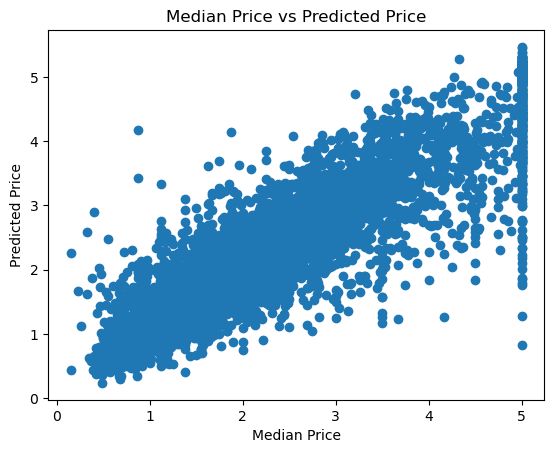

In [27]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Delete the endpoint

Since we are no longer using the deployed model we need to make sure to shut it down. Remember that you have to pay for the length of time that your endpoint is deployed so the longer it is left running, the more it costs.

In [ ]:
xgb_predictor.delete_endpoint()